## 我靠！这么低的正确率
模型这么低的accuracy肯定是CNN structure哪个地方错了
对于CNN做语言的感想<br>
其实看了一下模型，感觉到和fasttext大同小异。fasttext是从列进行一个pool。以100dimension为例的wordvector<br>
fasttext 只是将sen len*1 进行一个pooling得到100*1的output！<br>
用CNN的优点是模型设计比较方便，可以同时进行几个kernel size进行pooling，这样更加方便去提取语言之间不同的特征值。


In [1]:
import torch
from torchtext.legacy import data
from torchtext.legacy import datasets
import random
import numpy as np

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize = 'spacy', 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

train_data, test_data = datasets.IMDB.splits(TEXT, LABEL)

train_data, valid_data = train_data.split(random_state = random.seed(SEED))

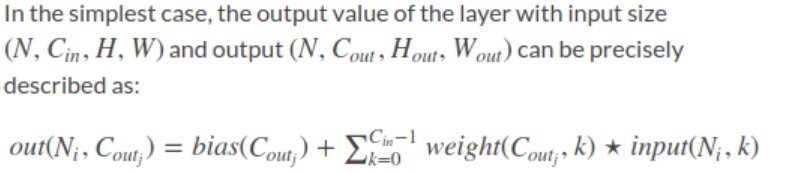

In [5]:
##单位矩阵来模拟输入
from torch.autograd import Variable

input1=torch.ones(1,3,5,5)
input1=Variable(input1)
x=torch.nn.Conv2d(in_channels=3,out_channels=4,kernel_size=3,groups=1)
out=x(input1)
print(out.shape)
print(list(x.parameters()))

torch.Size([1, 4, 3, 3])
[Parameter containing:
tensor([[[[ 0.1230, -0.0632, -0.1119],
          [ 0.0560, -0.1655,  0.1858],
          [-0.0680, -0.1333, -0.1421]],

         [[-0.1235,  0.0872,  0.0407],
          [-0.1818, -0.1248, -0.0653],
          [ 0.0240, -0.1417, -0.0923]],

         [[-0.1174,  0.0053,  0.0530],
          [-0.0855, -0.0299,  0.1240],
          [-0.1523,  0.0570,  0.1240]]],


        [[[-0.1735, -0.0630,  0.1800],
          [-0.0205,  0.1895,  0.1206],
          [ 0.1286,  0.0128, -0.0357]],

         [[-0.1546,  0.0540, -0.0446],
          [-0.0859, -0.1618,  0.1495],
          [ 0.1212,  0.0532, -0.0677]],

         [[ 0.0773,  0.1408,  0.0633],
          [-0.1111, -0.0230, -0.1805],
          [ 0.0347, -0.1646,  0.1695]]],


        [[[ 0.1463, -0.0514,  0.0712],
          [ 0.0878, -0.0175,  0.0511],
          [ 0.1156, -0.1130, -0.0891]],

         [[ 0.1569,  0.0728, -0.1590],
          [-0.1542, -0.1097,  0.1198],
          [ 0.0616, -0.1523, -0.1168]

In [3]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_data, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_data)

BATCH_SIZE = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size = BATCH_SIZE, 
    device = device)

In [43]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self , vocab_size , embedding_dim , output_dim , n_filters , 
                pad_idx , filter_sizes , dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size , embedding_dim , padding_idx = pad_idx)
        self.conv_0 = nn.Conv2d(in_channels = 1,
                               out_channels = n_filters,
                               kernel_size = (filter_sizes[0],embedding_dim))
#         self.conv_0 = nn.Conv2d(in_channels = 1, 
#                                 out_channels = n_filters, 
#                                 kernel_size = (filter_sizes[0], embedding_dim))
        self.conv_1 = nn.Conv2d(in_channels = 1,
                               out_channels = n_filters,
                               kernel_size = (filter_sizes[0],embedding_dim))
        self.conv_2 = nn.Conv2d(in_channels = 1,
                               out_channels = n_filters,
                               kernel_size = (filter_sizes[0],embedding_dim))
        self.fc = nn.Linear(len(filter_sizes)*n_filters , output_dim)
        self.dropout = nn.Dropout(dropout)
    def forward(self , x):
        #x shape = [batch_size , len sen]
        embedded = self.embedding(x)
        # [batch size , len sen , embedding_dim]
        embedded = embedded.unsqueeze(1)
        # [batch size ,1 ,  len sen , embedding_dim]
        conved_0 = F.relu(self.conv_0(embedded).squeeze(3))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(3))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(3))
        # [ batch_size , filters , len sentence-filter_sizes +1]
        
        pooled_0 = F.max_pool1d(conved_0 ,conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1 ,conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2 ,conved_2.shape[2]).squeeze(2)
        
        # [batch size , filters ]
        cat = self.dropout(torch.cat((pooled_0,pooled_1,pooled_2 ),dim = 1)  )
        
        #cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

        

In [34]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

In [44]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 100
FILTER_SIZES = [3,4,5]
OUTPUT_DIM = 1
DROPOUT = 0.5
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM , EMBEDDING_DIM , OUTPUT_DIM , N_FILTERS , 
                PAD_IDX , FILTER_SIZES , DROPOUT)

In [45]:
pretrained_embeddings = TEXT.vocab.vectors

model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[-0.1117, -0.4966,  0.1631,  ...,  1.2647, -0.2753, -0.1325],
        [-0.8555, -0.7208,  1.3755,  ...,  0.0825, -1.1314,  0.3997],
        [-0.0382, -0.2449,  0.7281,  ..., -0.1459,  0.8278,  0.2706],
        ...,
        [-0.3617,  0.6201,  0.1105,  ...,  0.2994, -0.5920,  1.0949],
        [-1.5604, -0.2112,  0.0090,  ..., -0.3807,  0.6190, -1.2712],
        [-0.1954,  0.5692, -0.0671,  ...,  0.2170,  0.7001, -0.1479]])

In [39]:
UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [24]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [25]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division 
    acc = correct.sum() / len(correct)
    return acc

In [26]:
def train(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label)
        
        acc = binary_accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [27]:
def evaluate(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label)
            
            acc = binary_accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [28]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [46]:
N_EPOCHS = 5

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut4-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 5m 4s
	Train Loss: 0.815 | Train Acc: 49.95%
	 Val. Loss: 0.761 |  Val. Acc: 50.74%
Epoch: 02 | Epoch Time: 5m 35s
	Train Loss: 0.811 | Train Acc: 50.20%
	 Val. Loss: 0.761 |  Val. Acc: 50.74%
Epoch: 03 | Epoch Time: 5m 12s
	Train Loss: 0.814 | Train Acc: 50.00%
	 Val. Loss: 0.761 |  Val. Acc: 50.74%
Epoch: 04 | Epoch Time: 5m 20s
	Train Loss: 0.814 | Train Acc: 49.83%
	 Val. Loss: 0.761 |  Val. Acc: 50.74%
Epoch: 05 | Epoch Time: 5m 14s
	Train Loss: 0.816 | Train Acc: 49.83%
	 Val. Loss: 0.761 |  Val. Acc: 50.74%
